# STEPS
1. From list of the ASF Sentinel-1 images extract info about datetime and date of making the photo. Extract also image LAT and LON along with the image width and height in pixels. 
2. From list of the AIS data extract info about the date of data. 
3. Join both dataframes (merge them). 

In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
from osgeo import gdal

In [2]:
data_directory = 'data/'
asf_data_directory = data_directory + '3_processed_ASF_data/'
ais_data_directory = data_directory + '2_raw_AIS_csv_data/'
processed_ais_data_directory = data_directory +  '4_processed_AIS_data/'
interpolated_AIS_data_directory = data_directory + '5_interpolated_AIS_data/'
results_directory = 'results/'

In [12]:
# constants
TIME_WINDOW = 10 # in minutes, +/- how much time to take into consideration between datetime of making the photo
USE_END_DATETIME = True

## PREPARE DATAFRAME

In [24]:
# read datetimes of making photos
asf_files_list = os.listdir(asf_data_directory)
asf_files_list = [ filename for filename in asf_files_list if filename.endswith('.tif') ]
# for element in asf_files_list:
#     if not element.endswith('.tif'):
#         asf_files_list.remove(element)

asf_files_list

['S1A_IW_GRDH_1SDV_20210204T015812_20210204T015841_036434_0446E1_2157_TC.tif',
 'S1B_IW_GRDH_1SDV_20210105T015737_20210105T015806_025013_02FA23_627F_TC.tif',
 'S1B_IW_GRDH_1SDV_20210306T015735_20210306T015804_025888_031671_7F65_TC.tif']

In [17]:
asf_images_tuples_list = list()

for asf_file in asf_files_list:
    datetime_counter = 0
    print(f"ASF file: {asf_file}")
    asf_file_splitted = asf_file.split('_')
    print(asf_file_splitted)
    datetime_pattern = re.compile("[A-Za-z0-9]+")
    for element in asf_file_splitted:
        if len(element) == 15:
            if datetime_pattern.match(element):
                datetime_counter += 1
                print(element)
                IMAGE_DATE = element[0:4] + '-' + element[4:6] + '-' + element[6:8]
                IMAGE_DATETIME = IMAGE_DATE + ' ' + element[9:11] + ':' + element[11:13] + ':' + element[13:15]
                #print(IMAGE_DATETIME)
                if datetime_counter == 1:
                    START_DATETIME = IMAGE_DATETIME
                elif datetime_counter == 2:
                    END_DATETIME = IMAGE_DATETIME
                    break # this break is here purposedly and is necessary                 
    
    if USE_END_DATETIME == False:
        IMAGE_DATETIME = START_DATETIME
    else:
        IMAGE_DATETIME = END_DATETIME

    # LAT and LON calculations
    ds = gdal.Open(asf_data_directory + asf_file)
    width = ds.RasterXSize
    height = ds.RasterYSize
    gt = ds.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3] 
    # final tuple
    asf_images_tuples_list.append((asf_file, IMAGE_DATETIME, IMAGE_DATE, minx, miny, maxx, maxy, width, height))

asf_df = pd.DataFrame(asf_images_tuples_list, columns =['asf_file', 'image_datetime', 'date', 'minLON', 'minLAT', 'maxLON', 'maxLAT', 'widthpx', 'heightpx'])
asf_df.image_datetime = pd.to_datetime(asf_df.image_datetime)
# boundaries +/- 10 minut
asf_df['datetime_lower'] = asf_df['image_datetime'] - timedelta(hours=0, minutes=TIME_WINDOW, seconds=0)
asf_df['datetime_upper'] = asf_df['image_datetime'] + timedelta(hours=0, minutes=TIME_WINDOW, seconds=0)
display(asf_df)

ASF file: S1A_IW_GRDH_1SDV_20210204T015812_20210204T015841_036434_0446E1_2157_TC.tif
['S1A', 'IW', 'GRDH', '1SDV', '20210204T015812', '20210204T015841', '036434', '0446E1', '2157', 'TC.tif']
20210204T015812
20210204T015841
ASF file: S1B_IW_GRDH_1SDV_20210105T015737_20210105T015806_025013_02FA23_627F_TC.tif
['S1B', 'IW', 'GRDH', '1SDV', '20210105T015737', '20210105T015806', '025013', '02FA23', '627F', 'TC.tif']
20210105T015737
20210105T015806
ASF file: S1B_IW_GRDH_1SDV_20210306T015735_20210306T015804_025888_031671_7F65_TC.tif
['S1B', 'IW', 'GRDH', '1SDV', '20210306T015735', '20210306T015804', '025888', '031671', '7F65', 'TC.tif']
20210306T015735
20210306T015804


,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper
0,S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158...,2021-02-04 01:58:41,2021-02-04,-118.496252,33.197789,-117.964359,33.855266,5921,7319,2021-02-04 01:48:41,2021-02-04 02:08:41
1,S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...,2021-01-05 01:58:06,2021-01-05,-118.575269,33.251929,-117.946359,33.930247,7001,7551,2021-01-05 01:48:06,2021-01-05 02:08:06
2,S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158...,2021-03-06 01:58:04,2021-03-06,-118.482835,33.199482,-117.980677,33.829740,5590,7016,2021-03-06 01:48:04,2021-03-06 02:08:04


In [28]:
ais_files_list = os.listdir(ais_data_directory)
ais_files_list = [ filename for filename in ais_files_list if filename.endswith('.csv') ]
# for element in ais_files_list:
#     if not element.endswith('.csv'):
#         ais_files_list.remove(element)
ais_files_list

['AIS_2021_01_05.csv', 'AIS_2021_02_04.csv', 'AIS_2021_03_06.csv']

In [29]:
ais_images_tuples_list = list()

for ais_file in ais_files_list:
    #print(ais_file)
    ais_file_splitted = ais_file.split('_')
    #print(ais_file_splitted)
    AIS_FILE_DATE = ais_file_splitted[1] + '-' + ais_file_splitted[2] + '-' + ais_file_splitted[3].split('.')[0]
    #print(AIS_FILE_DATE)
    ais_images_tuples_list.append((ais_file, AIS_FILE_DATE))
    
ais_df = pd.DataFrame(ais_images_tuples_list, columns =['ais_file', 'date'])
display(ais_df)

,ais_file,date
0,AIS_2021_01_05.csv,2021-01-05
1,AIS_2021_02_04.csv,2021-02-04
2,AIS_2021_03_06.csv,2021-03-06


In [30]:
full_data_df = asf_df.merge(ais_df, on='date')
full_data_df

,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper,ais_file
0,S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158...,2021-02-04 01:58:41,2021-02-04,-118.496252,33.197789,-117.964359,33.855266,5921,7319,2021-02-04 01:48:41,2021-02-04 02:08:41,AIS_2021_02_04.csv
1,S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...,2021-01-05 01:58:06,2021-01-05,-118.575269,33.251929,-117.946359,33.930247,7001,7551,2021-01-05 01:48:06,2021-01-05 02:08:06,AIS_2021_01_05.csv
2,S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158...,2021-03-06 01:58:04,2021-03-06,-118.482835,33.199482,-117.980677,33.829740,5590,7016,2021-03-06 01:48:04,2021-03-06 02:08:04,AIS_2021_03_06.csv


In [31]:
# save your work
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print(current_datetime)
full_data_df.to_csv(results_directory + current_datetime + '_full_data_df.csv')

2022-11-03_01-12-44


## WORK ON THE PREPARED DATAFRAME

### Restrict data by the given conditions

In [34]:
#full_data_df = pd.read_csv(results_directory + "2022-11-03_01-12-44_full_data_df.csv", index_col=0)
full_data_df

,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper,ais_file
0,S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158...,2021-02-04 01:58:41,2021-02-04,-118.496252,33.197789,-117.964359,33.855266,5921,7319,2021-02-04 01:48:41,2021-02-04 02:08:41,AIS_2021_02_04.csv
1,S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...,2021-01-05 01:58:06,2021-01-05,-118.575269,33.251929,-117.946359,33.930247,7001,7551,2021-01-05 01:48:06,2021-01-05 02:08:06,AIS_2021_01_05.csv
2,S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158...,2021-03-06 01:58:04,2021-03-06,-118.482835,33.199482,-117.980677,33.829740,5590,7016,2021-03-06 01:48:04,2021-03-06 02:08:04,AIS_2021_03_06.csv


In [35]:
for index, row in full_data_df.iterrows():
    print(row['ais_file'])
    file_path = ais_data_directory + str(row['ais_file'])
    ais_full_data = pd.read_csv(file_path)
    #display(ais_full_data)
    # condition for latitude: between 19.193 and 21.1203
    condition1 = (ais_full_data.LAT > row['minLAT']) & (ais_full_data.LAT < row['maxLAT'])
    # condition for latitude: between -157.0894 and -154.4233
    condition2 = (ais_full_data.LON > row['minLON']) & (ais_full_data.LON < row['maxLON'])
    # final dataframe
    target_area = ais_full_data[condition1 & condition2]
    #display(target_area)
    # target area contains 5542 rows × 17 columns
    target_area.reset_index(drop=True, inplace=True)
    target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)
    #display(target_area)
    # filter by date: from 2021-01-05 00:00:00 to 2021-01-05 23:59:59
    DATE1 = row['datetime_lower']
    DATE2 = row['datetime_upper']
    target_area_and_time = target_area[(target_area.BaseDateTime >= DATE1) & (target_area.BaseDateTime <= DATE2)]
    target_area_and_time.reset_index(drop=True, inplace=True)
    target_area_and_time.sort_values(by='BaseDateTime', 
                                     axis=0, 
                                     ascending=True, 
                                     inplace=True, 
                                     kind='quicksort', 
                                     na_position='last', 
                                     ignore_index=True)
    #display(target_area_and_time)
    
    saving_name = 'processed_' + row['ais_file']
    target_area_and_time.to_csv(processed_ais_data_directory + saving_name)
    # all data is from 4th January 2021

AIS_2021_02_04.csv


C:\Users\Guest\miniconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/45401384.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area_and_time.sort_values(by='BaseDateTime',


AIS_2021_01_05.csv


C:\Users\Guest\miniconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/45401384.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area_and_time.sort_values(by='BaseDateTime',


AIS_2021_03_06.csv


C:\Users\Guest\miniconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/45401384.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area_and_time.sort_values(by='BaseDateTime',


### Use algorithm to predict the best value from the TIME_WINDOW. 

In [36]:
#full_data_df = pd.read_csv(results_directory + "2022-10-15_16-37-28_full_data_df.csv", index_col=0)
full_data_df['processed_ais_file'] = 'processed_' + full_data_df['ais_file']
display(full_data_df)

,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper,ais_file,processed_ais_file
0,S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158...,2021-02-04 01:58:41,2021-02-04,-118.496252,33.197789,-117.964359,33.855266,5921,7319,2021-02-04 01:48:41,2021-02-04 02:08:41,AIS_2021_02_04.csv,processed_AIS_2021_02_04.csv
1,S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...,2021-01-05 01:58:06,2021-01-05,-118.575269,33.251929,-117.946359,33.930247,7001,7551,2021-01-05 01:48:06,2021-01-05 02:08:06,AIS_2021_01_05.csv,processed_AIS_2021_01_05.csv
2,S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158...,2021-03-06 01:58:04,2021-03-06,-118.482835,33.199482,-117.980677,33.829740,5590,7016,2021-03-06 01:48:04,2021-03-06 02:08:04,AIS_2021_03_06.csv,processed_AIS_2021_03_06.csv


In [37]:
def calculate_lin_reg_coefficients(x1, y1, x2, y2):
    """
    x is LON (longitude)
    y is LAT (latitude)
    """
    # y = ax + b
    #y1 = a*x1 + b
    #b = y1 - a*x1    
    #y2 = a*x2 + y1 - a*x1
    #y2 - y1 = a*x2 - a*x1
    #y2 - y1 = a*(x2-x1)    
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a*x1
    return a, b

In [38]:
list_of_df_dicts_after_lin_reg = list()

for index, row in full_data_df.iterrows():
    print(row['processed_ais_file'])
    image_datetime = pd.to_datetime(row['image_datetime'])
    print('image_datetime:', image_datetime)
    file_path = processed_ais_data_directory + str(row['processed_ais_file'])
    processed_ais_full_data = pd.read_csv(file_path, index_col=0)
    processed_ais_full_data.BaseDateTime = pd.to_datetime(processed_ais_full_data.BaseDateTime)
    #display(processed_ais_full_data)
    
    # for every ship
    list_of_unique_ships = processed_ais_full_data.MMSI.unique()
    #display(list_of_unique_ships)
    
    for ship in list_of_unique_ships:
        print('ship:', ship)
        working_df = processed_ais_full_data[processed_ais_full_data.MMSI == ship]
        working_df.reset_index(drop=True, inplace=True)
        #display(working_df)
        working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
        # SORT TABLE ASCENDINGLY
        working_df.sort_values(by='time_difference', 
                                 axis=0, 
                                 ascending=True, 
                                 inplace=True, 
                                 kind='quicksort', 
                                 na_position='last', 
                                 ignore_index=True)
        #display(working_df)
        
        if working_df.shape[0] > 1: # number of rows has to be greater than 1
            #trasform datetime to integer - first 2 rows of sorted dataframe by time_difference
            time1 = working_df['BaseDateTime'][0]
            time2 = working_df['BaseDateTime'][1]
            #print(f"time before conversion: {time1}, {time2}")

            # 1 opcja konwersji to zamiana całości daty i czasu na int (kosztowne obliczeniowo): 
            # 2021-02-04 01:57:13 -> 20210204015713
            #time1 = int(time1.strftime("%Y%m%d%H%M%S"))
            #time2 = int(time2.strftime("%Y%m%d%H%M%S"))

            # 2 opcja konwersji to zamiana tylko czasu na int (lepsze obliczeniowo): 
            # 2021-02-04 01:57:13 -> 15713
            time1 = int(time1.strftime("%H%M%S"))
            time2 = int(time2.strftime("%H%M%S"))
            #print(f"time after conversion: {time1}, {time2}")

            # calculate coefficient a1, b1 for LON (x)
            LON1 = working_df['LON'][0]
            LON2 = working_df['LON'][1]
            LAT1 = working_df['LAT'][0]
            LAT2 = working_df['LAT'][1]

            a1, b1 = calculate_lin_reg_coefficients(x1=time1, y1=LON1, x2=time2, y2=LON2)
            #print(f"LON equation: y = {a1}*x + {b1}")

            a2, b2 = calculate_lin_reg_coefficients(x1=time1, y1=LAT1, x2=time2, y2=LAT2)
            #print(f"LAT equation: y = {a2}*x + {b2}")

            time3 = int(image_datetime.strftime("%H%M%S"))
            #print(f"Image time after conversion: {time3}")

            image_LON = a1 * time3 + b1
            image_LAT = a2 * time3 + b2
            #print(f"Image LON: {image_LON}, LAT: {image_LAT}")
        else: 
            image_LON = working_df['LON'][0]
            image_LAT = working_df['LAT'][0]
        
        #prepare row for new dataframe
        # I take data from the first row (closest) from the two which I have used for calculations
        new_df_dict = {'MMSI': working_df['MMSI'][0],
                        'BaseDateTime': image_datetime,
                        'LAT': image_LAT,
                        'LON': image_LON,
                        'SOG': working_df['SOG'][0],
                        'COG': working_df['COG'][0],
                        'Heading': working_df['Heading'][0],
                        'VesselName': working_df['VesselName'][0],
                        'IMO': working_df['IMO'][0],
                        'CallSign': working_df['CallSign'][0],
                        'VesselType': working_df['VesselType'][0],
                        'Status': working_df['Status'][0],
                        'Length': working_df['Length'][0],
                        'Width': working_df['Width'][0],
                        'Draft': working_df['Draft'][0],
                        'Cargo': working_df['Cargo'][0],
                        'TranscieverClass': working_df['TranscieverClass'][0]}
        
        list_of_df_dicts_after_lin_reg.append(new_df_dict)
        #print(list_of_df_dicts_after_lin_reg)
    
    df_after_lin_reg = pd.DataFrame.from_dict(list_of_df_dicts_after_lin_reg)
    saving_name = 'interpolated_' + row['processed_ais_file']
    df_after_lin_reg.to_csv(interpolated_AIS_data_directory + saving_name)
    # all data is from 4th January 2021

processed_AIS_2021_02_04.csv
image_datetime: 2021-02-04 01:58:41
ship: 366785290
ship: 367033480
ship: 367724740
ship: 366932980
ship: 367691660
ship: 338228649
ship: 311603000
ship: 371274000
ship: 241501000
ship: 372361000
ship: 353162000
ship: 338083011
ship: 367621160
ship: 249414000
ship: 367733880
ship: 367309390
ship: 367642570
ship: 367133910
ship: 367397250
ship: 367647270
ship: 368024590
ship: 367422010
ship: 372955000
ship: 366979370
ship: 229622000
ship: 373285000
ship: 367368180
ship: 370587000
ship: 367049470
ship: 477219900
ship: 367676070
ship: 367657060
ship: 367599960
ship: 367308610
ship: 373828000
ship: 636018560
ship: 241618000
ship: 367506190
ship: 338322293
ship:

C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

 367702780
ship: 338240395
ship: 338364968
ship: 367044560
ship: 367393270
ship: 338392952
ship: 338304692
ship: 367719640
ship: 338926431
ship: 370407000
ship: 367101530
ship: 338319661
ship: 338209606
ship: 215189000
ship: 366760710
ship: 338186834
ship: 565032000
ship: 338368009
ship: 367760290
ship: 367550710
ship: 338139212
ship: 356289000
ship: 368064650
ship: 372218000
ship: 338160088
ship: 338311935
ship: 338369616
ship: 366755020
ship: 538008861
ship: 636017896
ship: 367793650
ship: 368117820
ship: 477857000
ship: 367507960
ship: 367004260
ship: 256937000
ship: 367014480
ship: 374645000
ship: 338334114
ship: 338376344
ship: 368104220
ship: 356696000
ship: 338366226
ship: 311000785
ship: 338226725
ship: 366734000
ship: 338380107
ship: 338380055
ship: 374158000
ship: 256608000
ship: 368141530
ship: 368020980
ship: 338182754
ship: 477056400
ship: 367578550
ship: 232024772
ship: 371449000
ship: 215354000


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

ship: 212351000
ship: 373021000
ship: 303031000
ship: 563090300
ship: 338362994
ship: 338228367
ship: 367008990
ship: 636092911
ship: 538007938
ship: 338239156
ship: 366855000
ship: 367492920
ship: 355800000
ship: 367570320
ship: 477866200
ship: 338035036
ship: 338321364
ship: 368021110
ship: 636013693
ship: 338127501
ship: 338335196
ship: 215164000
ship: 338388274
ship: 338120363
ship: 367616090
ship: 636019348
ship: 338097886
ship: 352375000
ship: 367559940
ship: 309955000
ship: 367682160
ship: 338181008
ship: 235093569
ship: 367486370
ship: 338137334
ship: 338146692
ship: 211311970
ship: 370500000
ship: 235009240
ship: 338328735
ship: 477738500
ship: 338209202
ship: 356581000
ship: 368850000
ship: 431315000
ship: 338225409
ship: 354277000
ship: 366746210
ship: 248052000
ship: 338181327
ship: 338328494
ship: 338092107
ship: 636013644
ship: 338324182
ship: 370361000
ship: 367709320
ship: 338139535
ship: 367015450
ship: 338229164
ship: 367562670
ship: 338396669
ship: 374527000
ship: 35

C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

ship: 368121180
ship: 338207261
ship: 636016204
ship: 636014805
ship: 338177481
ship: 538007480
ship: 209795000
ship: 369339000
ship: 338331664
ship: 311056900
ship: 371218000
ship: 367174120
ship: 338087117
ship: 477257100
ship: 248013000
ship: 367711690
ship: 636092268
ship: 338322535
ship: 373069000
ship: 354891000
ship: 338229302
ship: 338060204
ship: 338162425
ship: 338100018
ship: 235414000
ship: 368048380
ship: 310531000
ship: 566828000
ship: 338159837
ship: 338352671
ship: 255805859
ship: 338098732
ship: 366897980
ship: 338237068
ship: 368071660
ship: 366978720
ship: 368117610
ship: 367498530
ship: 338310725
ship: 636013530
ship: 338185756
ship: 338218665
ship: 366554000
ship: 338304048
ship: 367314820
ship: 367050320
ship: 338325903
ship: 338339764
ship: 367345120
ship: 338369179
ship: 338232506
ship: 309046000
ship: 367782540
ship: 338391781
ship: 367414180
ship: 366903130


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

ship: 338326628
ship: 338122738
ship: 369725000
ship: 338206407
ship: 338217105
ship: 241529000
ship: 366886630
ship: 338208967
ship: 338316979
ship: 367309720
ship: 366755010
ship: 366983530
ship: 366998840
ship: 367719100
ship: 368024740
ship: 368084540
ship: 367461940
ship: 367467120
ship: 366988960
ship: 369493652
ship: 367471080
ship: 367401030
ship: 367569830
ship: 368136950
ship: 366760650
ship: 366926740
ship: 367305920
ship: 366844270
ship: 368159190
ship: 338131199
ship: 416481000
ship: 367730310
ship: 367199310
ship: 367006770
ship: 367642530
ship: 367766860
ship: 367303000
ship: 367661930
ship: 338108125
ship: 338303738
ship: 367192970
ship: 565570000
ship: 367309330
ship: 256106000
ship: 367616390
ship: 538008132
ship: 357051000
ship: 310764000
ship: 367698890
ship: 636018854
ship: 355703000
ship: 338226227
ship: 368011010


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

processed_AIS_2021_01_05.csv
image_datetime: 2021-01-05 01:58:06
ship: 538007482
ship: 538004167
ship: 367452280
ship: 538007628
ship: 338322293
ship: 311044100
ship: 367395280
ship: 368024590
ship: 367569830
ship: 367719100
ship: 368064650
ship: 355442000
ship: 338380055
ship: 367049470
ship: 367760290
ship: 366755010
ship: 338207261
ship: 338145832
ship: 338209202
ship: 367414180


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

ship: 368048380
ship: 636019206
ship: 367754970
ship: 366951730
ship: 368141530
ship: 636091273
ship: 366979370
ship: 367616390
ship: 367599960
ship: 367199310
ship: 367733880
ship: 367471080
ship: 338326628
ship: 249577000
ship: 353243000
ship: 367422010
ship: 477136800
ship: 338209606
ship: 368011010
ship: 368117610
ship: 338303738
ship: 338229302
ship: 374527000
ship: 636018356
ship: 367678850
ship: 367133910
ship: 338098732
ship: 416495000
ship: 368123940
ship: 338334114
ship: 338159837
ship: 368136950
ship: 366998840
ship: 366983530
ship: 367506190
ship: 235098885
ship: 338217105
ship: 338566000
ship: 367104070
ship: 367507960
ship: 366760710
ship: 366785290
ship: 367008990
ship: 367698890
ship: 366978720
ship: 352361000
ship: 338131199
ship: 368165820
ship: 368159190
ship: 338926431
ship: 255805780
ship: 367578740
ship: 367308610
ship: 366823250
ship: 368068820


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

ship: 352822000
ship: 367661930
ship: 566958000
ship: 269804000
ship: 338100018
ship: 367693690
ship: 477845600
ship: 338087117
ship: 367691660
ship: 366844270
ship: 338162425
ship: 367369720
ship: 367014480
ship: 367309720
ship: 477528400
ship: 370361000
ship: 367461940
ship: 367401030
ship: 338366226
ship: 367616090
ship: 367044560
ship: 235098383
ship: 303656000
ship: 367711690
ship: 366857070
ship: 310764000
ship: 367305920
ship: 368073680
ship: 367647270
ship: 367004260
ship: 338380107
ship: 351848000
ship: 368084540
ship: 367642530
ship: 338240395
ship: 368024740
ship: 338926432
ship: 367682160


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

ship: 366760650
ship: 367303000
ship: 477738600
ship: 338322535
ship: 636018106
ship: 477742600
ship: 367676070
ship: 636017153
ship: 565963000
ship: 367793650
ship: 366755020
ship: 311827000
ship: 311603000
ship: 255805854
ship: 636019717
ship: 338186834
ship: 367516440
ship: 477014800
ship: 338310725
ship: 338139212
ship: 248699000
ship: 232018901
ship: 538008133
ship: 212348000
ship: 367646260
ship: 368850000
ship: 565473000
ship: 636091959
ship: 636018222
ship: 215240000
ship: 367709320
ship: 316020615
ship: 338500000
ship: 338364968
ship: 338311935
ship: 431260000
ship: 211433000
ship: 338316979
ship: 563073500
ship: 338185756
ship: 368104220
ship: 338225409
ship: 366554000
ship: 338304048
ship: 338331664
ship: 338218665


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

ship: 370188000
ship: 368124560
ship: 372955000
ship: 338324023
ship: 338083011
ship: 368117820
ship: 338325903
ship: 338362994
ship: 367408930
ship: 369567000
ship: 338208224
ship: 338092107
ship: 366768030
ship: 477904300
ship: 563061300
ship: 338226725
ship: 305293000
ship: 338229164
ship: 338368009
ship: 367650150
ship: 367015450
ship: 218441000
ship: 256932000
ship: 368054430
ship: 338321364
ship: 255806335
ship: 538007581
ship: 357104000
ship: 338304692
ship: 338388274
ship: 338339764
ship: 538007680
ship: 367559940
ship: 338921000
ship: 338228367
ship:

C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

 416464000
ship: 338352671
ship: 367562670
ship: 235335000
ship: 367309390
ship: 367655170
ship: 311008600
ship: 338181008
ship: 338146692
ship: 255806340
ship: 215181000
ship: 211331640
ship: 636013530
ship: 538007801
ship: 338035036
ship: 338226227
ship: 338120363
ship: 352871000
ship: 367472050
ship: 563090500
ship: 477655900
ship: 338328494
ship: 338177481
ship: 338137334
ship: 338139535
ship: 367467120
ship: 366903130
ship: 367492920
ship: 368129380
ship: 367486370
ship: 636018560
ship: 303352000
ship: 477133700
ship: 338310827
ship: 338328735
ship: 367309330
ship: 248895000
ship: 220416000
ship: 367657060
ship: 367050320
ship: 338335196
ship: 367174120
ship: 374158000
ship: 367627850
ship: 338369616
ship: 636017929
ship: 338127501
ship: 338208967
ship: 338232506


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

ship: 355433000
ship: 338364441
ship: 367101530
ship: 366932980
ship: 338181327
ship: 367314820
ship: 367033480
ship: 338239156
ship: 369725000
ship: 338324182
ship: 338393343
processed_AIS_2021_03_06.csv
image_datetime: 2021-03-06 01:58:04
ship: 366998840
ship: 636090967
ship: 303668000
ship: 368024740
ship: 636017154
ship: 367471080
ship: 311603000
ship: 372270000
ship: 367776050
ship: 636020371
ship:

C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

 368171260
ship: 338098732
ship: 367559940
ship: 229934000
ship: 367401030
ship: 338366226
ship: 367507960
ship: 367034960
ship: 367461940
ship: 367758240
ship: 367017440
ship: 366760710
ship: 373183000
ship: 366998830
ship: 366983530
ship: 368064650
ship: 245304000
ship: 367760290
ship: 338185756
ship: 367199310
ship: 319200700
ship: 367038000
ship: 338335159
ship: 416464000
ship: 338131199
ship: 212353000
ship: 338116961
ship: 367014480
ship: 367569830
ship: 366755010
ship: 354839000
ship: 477117900
ship: 338391781
ship: 366926740
ship: 367133910
ship: 338500000
ship: 367711690
ship: 636090862
ship: 374158000
ship: 354886000
ship: 338159837
ship: 338326628
ship: 338369616
ship: 241528000
ship: 338322535
ship: 367766860
ship: 367724740
ship: 538007479
ship: 370188000
ship: 366764730
ship: 367104070
ship: 368171990
ship: 338303738
ship: 367642530
ship: 311000112
ship: 232018919
ship: 366746210
ship: 367044560
ship: 338181008


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

ship: 355813000
ship: 368121180
ship: 229979000
ship: 636018356
ship: 338926430
ship: 338060204
ship: 368117820
ship: 366785290
ship: 338397183
ship: 367691660
ship: 232002990
ship: 477652300
ship: 563096700
ship: 338311935
ship: 367427670
ship: 367422280
ship: 636019206
ship: 367647270
ship: 367101530
ship: 366806940
ship: 368084540
ship: 367661930
ship: 367299000
ship: 367733880
ship: 367719100
ship: 367492920
ship: 366943940
ship: 431552000
ship: 311827000
ship: 367506190
ship: 338208967
ship: 367681720
ship: 367689990
ship: 219199000
ship: 367303000
ship: 354804000
ship: 368011010
ship: 367618150
ship: 372151000
ship: 367192970
ship: 338360094
ship: 368159190
ship: 366760650
ship: 367422010
ship: 366978720
ship: 367133160
ship: 367698890
ship: 368136950
ship: 338240395
ship: 367655460
ship: 366979370
ship: 367006770
ship: 368024590
ship: 367616090
ship: 636014997
ship: 367049470
ship: 338118674
ship: 367796420
ship: 477655200
ship: 367004260
ship: 371582000
ship: 338209376
ship: 35

C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

 338319175
ship: 366932980
ship: 368078070
ship: 338229164
ship: 310765000
ship: 311000111
ship: 367308610
ship: 366758000
ship: 367486370
ship: 369042000
ship: 431654000
ship: 338316979
ship: 351539000
ship: 367676070
ship: 366554000
ship: 215346000
ship: 368048380
ship: 303340000
ship: 367646260
ship: 636091959
ship: 255806335
ship: 413173000
ship: 366886630
ship: 338331664
ship: 368104220
ship: 367174120
ship: 219303000
ship: 367704790
ship: 538090583
ship: 338228367
ship: 338226725
ship: 538003788
ship: 338926432
ship: 338304048
ship: 338092107
ship: 563090400
ship: 636019213
ship: 367314820
ship: 338335196
ship: 477050500
ship: 431792000
ship: 538002733
ship: 367050320
ship: 338392988
ship: 338229302
ship: 338087117
ship: 338137334
ship: 366823250
ship: 368062490
ship: 352375000
ship: 368171390
ship: 338333431
ship: 368141530
ship: 338362994
ship: 367414180
ship: 374527000
ship: 355271000
ship: 338127501
ship: 368146890
ship: 338035036
ship: 338388274
ship: 354212000
ship: 3673097

C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

ship: 368119780
ship: 338310725
ship: 205784000
ship: 338121000
ship: 338322293
ship: 311000801
ship: 367033480
ship: 338146692
ship: 338325903
ship: 338351509
ship: 566958000
ship: 367599960
ship: 255805913
ship: 369725000
ship: 338207261
ship: 236728000
ship: 338364968
ship: 366951730
ship: 354314000
ship: 338391906
ship: 477148100
ship: 338396669
ship: 232018901
ship: 366897980
ship: 338328494
ship: 338380107
ship: 338181327
ship: 353524000
ship: 338186834
ship: 563066200
ship: 370739000
ship: 416465000
ship: 367709320
ship: 310768000
ship: 311000923
ship: 338339764
ship: 367762210
ship: 367089760
ship: 367682160
ship: 566942000
ship: 982463045
ship: 255805584
ship: 477170700
ship: 338247851
ship: 566949000
ship: 338226227
ship: 367778000
ship: 338122738
ship: 338177481
ship: 338393312
ship: 338199216
ship: 367793650
ship: 338218665
ship: 367550710


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

ship: 338139535
ship: 338393343
ship: 367796430
ship: 366745460
ship: 338125218
ship: 338347197
ship: 338083011
ship: 338209606
ship: 338310827


C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = abs(image_datetime - working_df['BaseDateTime'])
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='time_difference',
C:\Users\Guest\AppData\Local\Temp/ipykernel_4756/2599834810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

# RUBBISH

In [20]:
ds = gdal.Open(asf_data_directory + 'S1A_IW_GRDH_1SDV_20210204T015812_20210204T015841_036434_0446E1_2157_TC.tif')
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

In [21]:
minx, miny, maxx, maxy

(-118.4962518528152,
 33.19778878418238,
 -117.96435937308804,
 33.855265740629456)

In [22]:
gt

(-118.4962518528152,
 8.983152841195215e-05,
 0.0,
 33.855265740629456,
 0.0,
 -8.983152841195215e-05)

In [16]:
width, height

(5921, 7319)

In [97]:
full_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   asf_file        3 non-null      object
 1   image_datetime  3 non-null      object
 2   date            3 non-null      object
 3   ais_file        3 non-null      object
dtypes: object(4)
memory usage: 120.0+ bytes


In [107]:
full_data_df.describe()

,asf_file,image_datetime,date,datetime_lower,datetime_upper,ais_file
count,3,3,3,3,3,3
unique,3,3,3,3,3,3
top,S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...,2021-02-04 01:58:12,2021-03-06,2021-01-05 01:47:37,2021-02-04 02:08:12,AIS_2021_02_04.csv
freq,1,1,1,1,1,1
first,NaN,2021-01-05 01:57:37,NaN,2021-01-05 01:47:37,2021-01-05 02:07:37,NaN
last,NaN,2021-03-06 01:57:35,NaN,2021-03-06 01:47:35,2021-03-06 02:07:35,NaN


In [28]:
def use_regex(input_text):
    pattern = re.compile(r"[A-Za-z0-9]+", re.IGNORECASE)
    return pattern.match(input_text)

use_regex("hey")

<_sre.SRE_Match object; span=(0, 3), match='hey'>

# OLD

In [2]:
import pandas as pd
#from osgeo import gdal

### df.columns:
    'MMSI' - unique id (Maritime Mobile Service Identity value) [unikalne id w bazie MMS]
    'BaseDateTime' - date and time of taking the AIS photo (full UTC time)
    'LAT' - geographic latitude
    'LON'- geographic lontitude
    'SOG' - Speed Over Ground [in knots] = Prędkość nad ziemią [w węzłach]
    'COG' - Course Over Ground [in degrees] = Kurs nad ziemią [w stopniach]
    'Heading' - heading angle [in degrees] = kąt kursu statku
    'VesselName' - official name of the ship = nazwa statku
    'IMO' - ship id, International Maritime Organization Vessel number [unikalne id statku]
    'CallSign' - call sign assigned by FFC = [jakiś znaczek]
    'VesselType' = typ statku, np. rybacki, wojskowy zakodowany przez liczbę
    'Status' - navigation status = status nawigacji
    'Length' - length of the ship
    'Width' - width of the ship
    'Draft' - draft depth of vessel 
    'Cargo' - cargo on the ship = ładunek
    'TranscieverClass' - class of AIS transceiver = klasa nadajnika-odbiornika AIS
    
more: https://marinecadastre.gov/ais/faq/

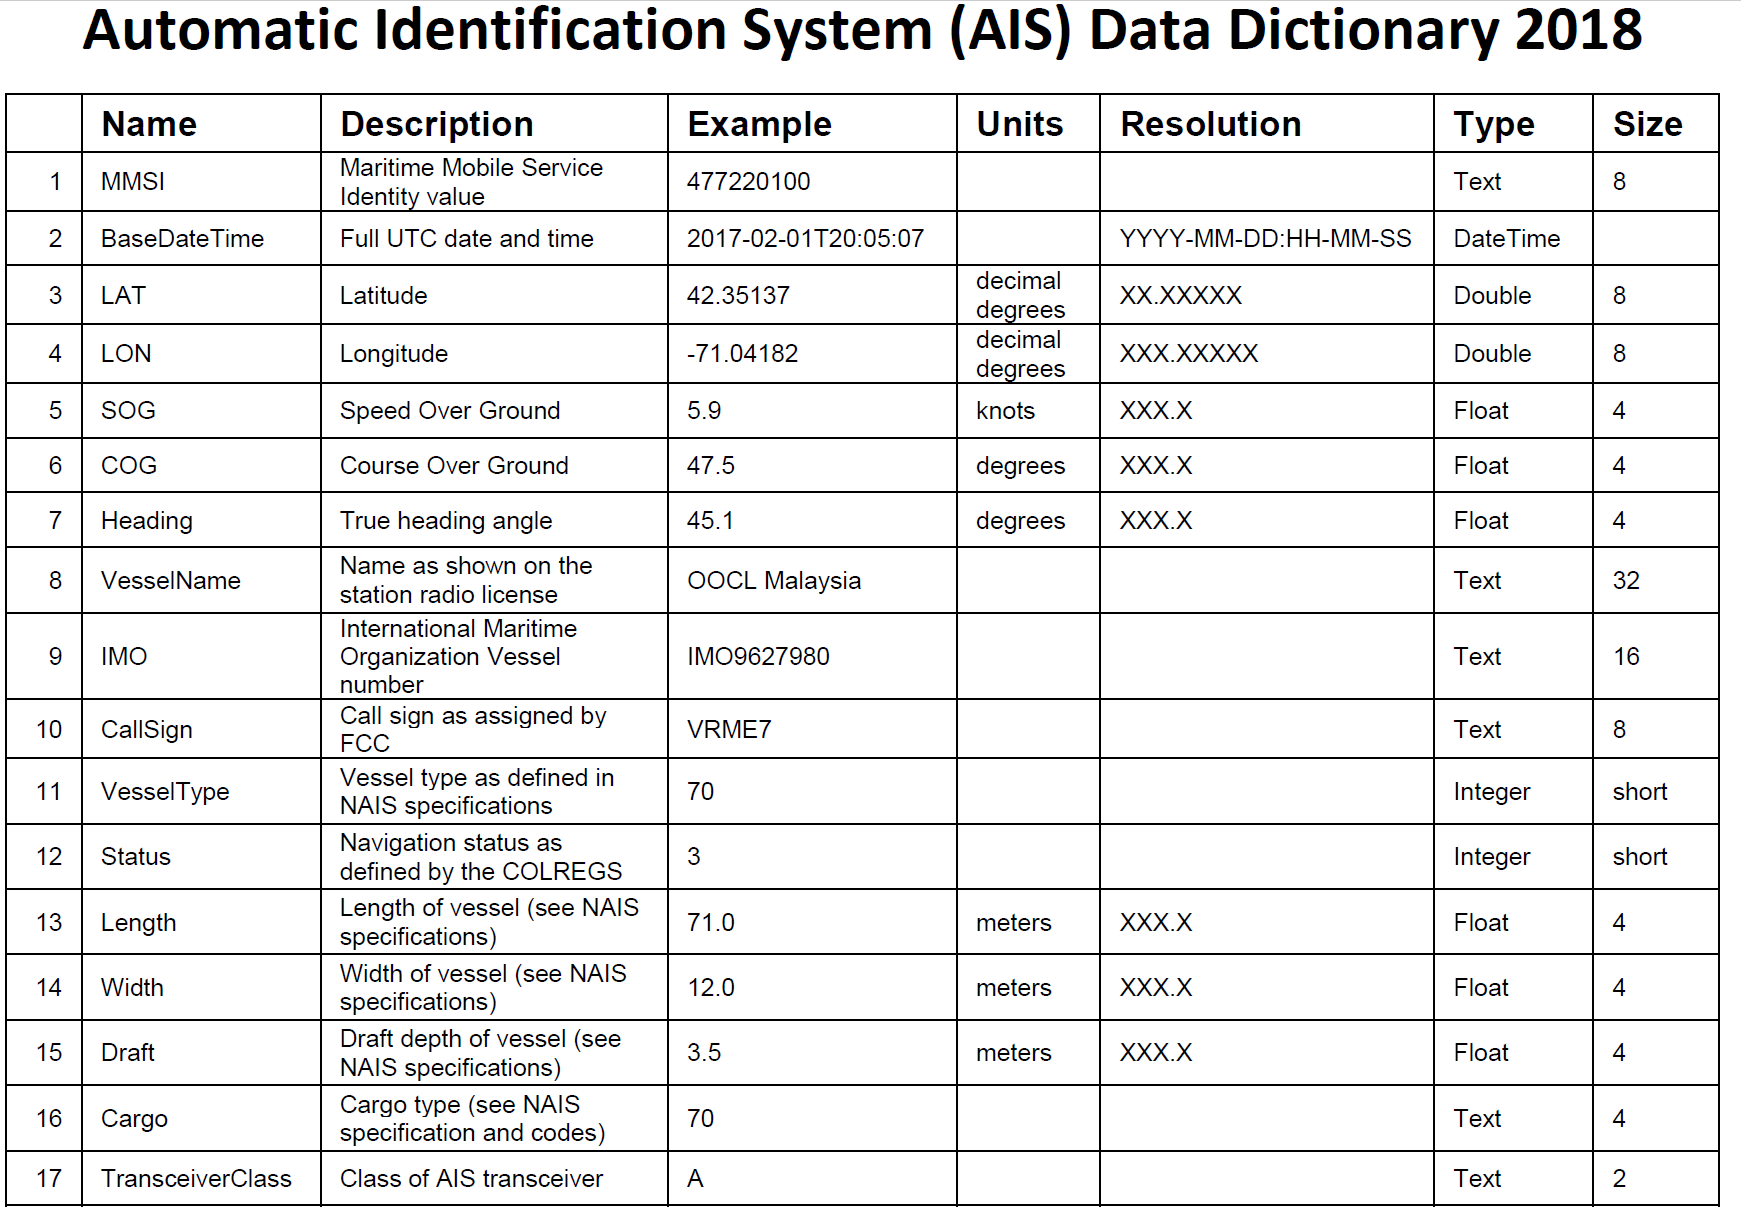

In [3]:
df = pd.read_csv('data/AIS_2021_01_05.csv')
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,368056750,2021-01-05T00:00:00,40.69279,-74.13655,0.0,159.9,352.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,368165820,2021-01-05T00:00:00,33.72340,-118.28067,0.0,241.5,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
2,368088610,2021-01-05T00:00:00,38.09991,-122.26283,0.0,64.8,54.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
3,248440000,2021-01-05T00:00:00,46.25754,-124.05879,9.1,262.0,260.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
4,368076480,2021-01-05T00:00:00,37.06903,-88.57099,7.4,287.9,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7664466,368926394,2021-01-05T23:26:18,13.45075,144.62116,0.6,282.9,511.0,NBG-2,IMO0000000,NBG2,57.0,NaN,0.0,0.0,NaN,NaN,B
7664467,369970581,2021-01-05T23:32:09,13.58121,144.83658,0.0,314.7,511.0,USN GUAM 1,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
7664468,369970581,2021-01-05T23:39:20,13.58121,144.83658,0.0,311.2,511.0,USN GUAM 1,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
7664469,369970581,2021-01-05T23:41:39,13.58120,144.83658,0.0,314.8,511.0,USN GUAM 1,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A


####  Nunique() values for about 7 million rows (7 525 725 rows) and 17 columns:
    04.01.2021
    MMSI                 14 470  
    BaseDateTime         86 359
    LAT               1 138 708
    LON               1 313 680
    SOG                     629
    COG                   3 601
    Heading                 365
    VesselName           11 725
    IMO                   3 963
    CallSign             10 409
    VesselType               49
    Status                   16
    Length                  315
    Width                    60
    Draft                   180
    Cargo                    65
    TranscieverClass          2
    
    05.01.2021
    MMSI                 14 434
    BaseDateTime          86341
    LAT                 1150104
    LON                 1350777
    SOG                     576
    COG                    3602
    Heading                 366
    VesselName            11718
    IMO                    4038
    CallSign              10455
    VesselType               50
    Status                   15
    Length                  317
    Width                    59
    Draft                   179
    Cargo                    66
    TranscieverClass          2

In [4]:
df.nunique()

MMSI                  14434
BaseDateTime          86341
LAT                 1150104
LON                 1350777
SOG                     576
COG                    3602
Heading                 366
VesselName            11718
IMO                    4038
CallSign              10455
VesselType               50
Status                   15
Length                  317
Width                    59
Draft                   179
Cargo                    66
TranscieverClass          2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7664471 entries, 0 to 7664470
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TranscieverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 994.1+ MB


## Load image data

In [6]:
info = gdal.Info('data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif', deserialize=True)
print(info) 

Driver: GTiff/GeoTIFF
Files: data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif
Size is 9611, 7847
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",50000

In [23]:
info2 = gdal.Info('data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif', deserialize=False)
print(info2) 

Driver: GTiff/GeoTIFF
Files: data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif
Size is 9611, 7847
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",50000

In [25]:
type(info)

str

In [28]:
?gdal.InfoOptions()

Object `gdal.InfoOptions()` not found.


In [26]:
?gdal.Info

In [11]:
gtif = gdal.Open('data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif')
print(gtif.GetMetadata())

{'AREA_OR_POINT': 'Point', 'TIFFTAG_DATETIME': '2022:06:18 00:37:26', 'TIFFTAG_SOFTWARE': 'Created with GAMMA Software www.gamma-rs.ch data2geotiff v2.9'}


In [12]:
# The dir() function is probably the most famous part of the Python introspection mechanism. 
# It can return a sorted list of attribute names of any objects passed to it. 
# If you do not specify an object, dir() returns the name in the current scope.
dir(gtif)

['AddBand',
 'AdviseRead',
 'BeginAsyncReader',
 'BuildOverviews',
 'CommitTransaction',
 'CopyLayer',
 'CreateLayer',
 'CreateMaskBand',
 'DeleteLayer',
 'EndAsyncReader',
 'ExecuteSQL',
 'FlushCache',
 'GetDescription',
 'GetDriver',
 'GetFileList',
 'GetGCPCount',
 'GetGCPProjection',
 'GetGCPSpatialRef',
 'GetGCPs',
 'GetGeoTransform',
 'GetLayer',
 'GetLayerByIndex',
 'GetLayerByName',
 'GetLayerCount',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetNextFeature',
 'GetProjection',
 'GetProjectionRef',
 'GetRasterBand',
 'GetSpatialRef',
 'GetStyleTable',
 'GetSubDatasets',
 'GetTiledVirtualMem',
 'GetTiledVirtualMemArray',
 'GetVirtualMem',
 'GetVirtualMemArray',
 'RasterCount',
 'RasterXSize',
 'RasterYSize',
 'ReadAsArray',
 'ReadRaster',
 'ReadRaster1',
 'ReleaseResultSet',
 'ResetReading',
 'RollbackTransaction',
 'SetDescription',
 'SetGCPs',
 'SetGeoTransform',
 'SetMetadata',
 'SetMetadataItem',
 'SetProjection',

In [20]:
print(gtif.GetProjectionRef())

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [21]:
print(gtif.GetDescription())

data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif


In [22]:
print(gtif.GetGeoTransform())

(138750.0, 30.0, 0.0, 3806130.0, 0.0, -30.0)


#### Data filtration
- LAT and LON columns are treated as floating point values
        2   LAT               float64
        3   LON               float64

Date and time of doing the photo:

    Start Time • 01/05/21, 01:57:37Z
    Stop Time • 01/05/21, 01:58:06Z
    Beam Mode • IW
    Path • 137
    Frame • 104
    Flight Direction • ASCENDING 
    Polarization • VV+VH 
    Absolute Orbit • 25013

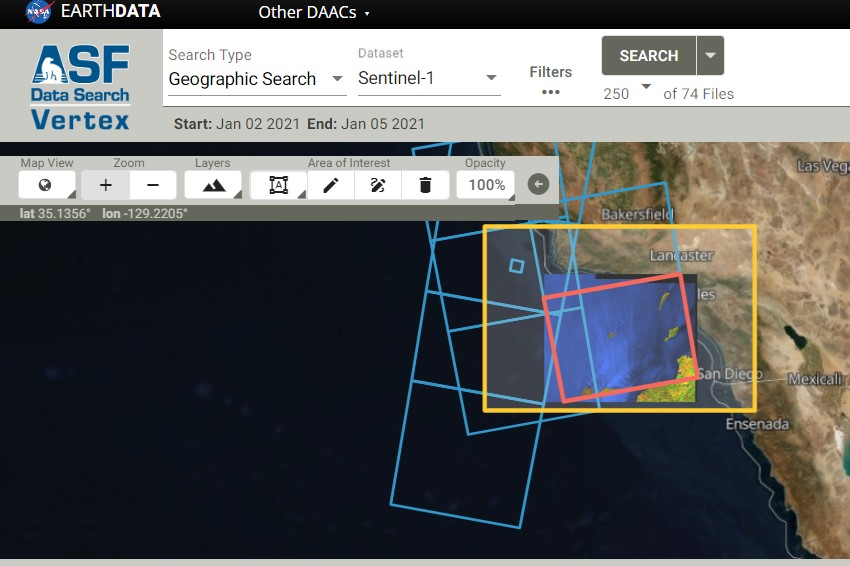

Corner Coordinates:

    Upper Left  (  138750.000, 3806130.000) (120d55'34.07"W, 34d20' 0.85"N)
    Lower Left  (  138750.000, 3570720.000) (120d49'56.25"W, 32d12'54.21"N)
    Upper Right (  427080.000, 3806130.000) (117d47'35.86"W, 34d23'38.45"N)
    Lower Right (  427080.000, 3570720.000) (117d46'27.41"W, 32d16'15.02"N)
    Center      (  282915.000, 3688425.000) (119d19'54.74"W, 33d18'47.16"N)

In [4]:
# lewy górny róg zdjęcia
LAT1 = 34.3909
LON1 = -120.8612
# prawy górny róg zdjęcia
LAT2 = 34.4076
LON2 = -117.8599
# lewy dolny róg zdjęcia
LAT3 = 32.2706
LON3 = -120.8813
# prawy dolny róg zdjęcia
LAT4 = 32.2706
LON4 = -117.8599

In [5]:
minLAT = min(LAT1, LAT2, LAT3, LAT4)
maxLAT = max(LAT1, LAT2, LAT3, LAT4)
minLAT, maxLAT

(32.2706, 34.4076)

In [6]:
minLON = min(LON1, LON2, LON3, LON4)
maxLON = max(LON1, LON2, LON3, LON4)
minLON, maxLON

(-120.8813, -117.8599)

In [30]:
type(LON1)

float

In [7]:
# condition for latitude: between 19.193 and 21.1203
condition1 = (df.LAT > minLAT) & (df.LAT < maxLAT)
# condition for latitude: between -157.0894 and -154.4233
condition2 = (df.LON > minLON) & (df.LON < maxLON)
# final dataframe
target_area = df[condition1 & condition2]
target_area
# target area contains 5542 rows × 17 columns

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
1,368165820,2021-01-05T00:00:00,33.72340,-118.28067,0.0,241.5,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
20,636018560,2021-01-05T00:00:01,33.73400,-118.25050,0.0,16.0,71.0,SEALAND GUAYAQUIL,IMO9383259,A8QP3,71.0,5.0,209.0,30.0,8.5,71.0,A
30,338094686,2021-01-05T00:00:05,33.61102,-117.92361,0.0,294.7,289.0,ALESSA LEIGH,NaN,WDB4997,37.0,0.0,28.0,6.0,2.5,37.0,A
53,367506190,2021-01-05T00:00:40,33.72427,-118.28149,0.0,135.5,511.0,THALASSA,NaN,WDF9539,37.0,NaN,15.0,NaN,NaN,NaN,B
66,367678390,2021-01-05T00:00:01,33.61365,-117.92475,0.0,267.5,226.0,EL TIGRE,NaN,WDI2461,37.0,0.0,19.0,6.0,NaN,0.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7652903,366966550,2021-01-05T23:57:27,34.24270,-119.26405,0.0,330.0,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
7652955,368019930,2021-01-05T23:58:05,34.14784,-119.20300,0.0,62.6,268.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
7652980,255805854,2021-01-05T23:58:22,33.75247,-118.27431,0.0,328.5,330.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
7653012,311000902,2021-01-05T23:58:40,33.73498,-118.15873,0.0,277.5,259.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,A


#### BaseDateTime is a string
    1   BaseDateTime      object 

In [8]:
target_area.reset_index(drop=True, inplace=True)
target_area

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,368165820,2021-01-05T00:00:00,33.72340,-118.28067,0.0,241.5,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,636018560,2021-01-05T00:00:01,33.73400,-118.25050,0.0,16.0,71.0,SEALAND GUAYAQUIL,IMO9383259,A8QP3,71.0,5.0,209.0,30.0,8.5,71.0,A
2,338094686,2021-01-05T00:00:05,33.61102,-117.92361,0.0,294.7,289.0,ALESSA LEIGH,NaN,WDB4997,37.0,0.0,28.0,6.0,2.5,37.0,A
3,367506190,2021-01-05T00:00:40,33.72427,-118.28149,0.0,135.5,511.0,THALASSA,NaN,WDF9539,37.0,NaN,15.0,NaN,NaN,NaN,B
4,367678390,2021-01-05T00:00:01,33.61365,-117.92475,0.0,267.5,226.0,EL TIGRE,NaN,WDI2461,37.0,0.0,19.0,6.0,NaN,0.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297362,366966550,2021-01-05T23:57:27,34.24270,-119.26405,0.0,330.0,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
297363,368019930,2021-01-05T23:58:05,34.14784,-119.20300,0.0,62.6,268.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
297364,255805854,2021-01-05T23:58:22,33.75247,-118.27431,0.0,328.5,330.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
297365,311000902,2021-01-05T23:58:40,33.73498,-118.15873,0.0,277.5,259.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,A


In [9]:
# from datetime import datetime
# from datetime import timezone

# datetime.fromisoformat('2020-01-06T00:00:00.000Z'[:-1]).astimezone(timezone.utc)
# datetime.datetime(2020, 1, 6, 3, 0, tzinfo=datetime.timezone.utc)

In [10]:
# d = datetime.fromisoformat('2020-01-06T00:00:00.000Z'[:-1]).astimezone(timezone.utc)
# d.strftime('%Y-%m-%d %H:%M:%S')

In [9]:
target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)

C:\Users\Darek_PC\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
target_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297367 entries, 0 to 297366
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   MMSI              297367 non-null  int64         
 1   BaseDateTime      297367 non-null  datetime64[ns]
 2   LAT               297367 non-null  float64       
 3   LON               297367 non-null  float64       
 4   SOG               297367 non-null  float64       
 5   COG               297367 non-null  float64       
 6   Heading           297367 non-null  float64       
 7   VesselName        261978 non-null  object        
 8   IMO               156140 non-null  object        
 9   CallSign          184887 non-null  object        
 10  VesselType        260973 non-null  float64       
 11  Status            165144 non-null  float64       
 12  Length            235589 non-null  float64       
 13  Width             201181 non-null  float64       
 14  Draf

#### BaseDateTime is a datetime
    1   BaseDateTime      5542 non-null   datetime64[ns]

In [11]:
target_area

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,368165820,2021-01-05 00:00:00,33.72340,-118.28067,0.0,241.5,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,636018560,2021-01-05 00:00:01,33.73400,-118.25050,0.0,16.0,71.0,SEALAND GUAYAQUIL,IMO9383259,A8QP3,71.0,5.0,209.0,30.0,8.5,71.0,A
2,338094686,2021-01-05 00:00:05,33.61102,-117.92361,0.0,294.7,289.0,ALESSA LEIGH,NaN,WDB4997,37.0,0.0,28.0,6.0,2.5,37.0,A
3,367506190,2021-01-05 00:00:40,33.72427,-118.28149,0.0,135.5,511.0,THALASSA,NaN,WDF9539,37.0,NaN,15.0,NaN,NaN,NaN,B
4,367678390,2021-01-05 00:00:01,33.61365,-117.92475,0.0,267.5,226.0,EL TIGRE,NaN,WDI2461,37.0,0.0,19.0,6.0,NaN,0.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297362,366966550,2021-01-05 23:57:27,34.24270,-119.26405,0.0,330.0,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
297363,368019930,2021-01-05 23:58:05,34.14784,-119.20300,0.0,62.6,268.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
297364,255805854,2021-01-05 23:58:22,33.75247,-118.27431,0.0,328.5,330.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
297365,311000902,2021-01-05 23:58:40,33.73498,-118.15873,0.0,277.5,259.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,A


In [12]:
# filter by date: from 2021-01-05 00:00:00 to 2021-01-05 23:59:59
DATE1 = '2021-01-05 00:00:00'
DATE2 = '2021-01-05 23:59:59'
target_area_and_time = target_area[(target_area.BaseDateTime >= DATE1) & (target_area.BaseDateTime <= DATE2)]
target_area_and_time
# all data is from 4th January 2021

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,368165820,2021-01-05 00:00:00,33.72340,-118.28067,0.0,241.5,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,636018560,2021-01-05 00:00:01,33.73400,-118.25050,0.0,16.0,71.0,SEALAND GUAYAQUIL,IMO9383259,A8QP3,71.0,5.0,209.0,30.0,8.5,71.0,A
2,338094686,2021-01-05 00:00:05,33.61102,-117.92361,0.0,294.7,289.0,ALESSA LEIGH,NaN,WDB4997,37.0,0.0,28.0,6.0,2.5,37.0,A
3,367506190,2021-01-05 00:00:40,33.72427,-118.28149,0.0,135.5,511.0,THALASSA,NaN,WDF9539,37.0,NaN,15.0,NaN,NaN,NaN,B
4,367678390,2021-01-05 00:00:01,33.61365,-117.92475,0.0,267.5,226.0,EL TIGRE,NaN,WDI2461,37.0,0.0,19.0,6.0,NaN,0.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297362,366966550,2021-01-05 23:57:27,34.24270,-119.26405,0.0,330.0,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
297363,368019930,2021-01-05 23:58:05,34.14784,-119.20300,0.0,62.6,268.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
297364,255805854,2021-01-05 23:58:22,33.75247,-118.27431,0.0,328.5,330.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
297365,311000902,2021-01-05 23:58:40,33.73498,-118.15873,0.0,277.5,259.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,A


In [13]:
# DATETIME of the photo:
#Start Time • 01/05/21, 01:57:37Z
#Stop Time • 01/05/21, 01:58:06Z
# filter by date: from 2021-01-05 01:47:00 to 2021-01-05 02:07:00
DATE3 = '2021-01-05 01:57:37'
DATE4 = '2021-01-05 01:58:06'
chosen_target_area_and_time = target_area_and_time[(target_area_and_time.BaseDateTime >= DATE3) & (target_area_and_time.BaseDateTime <= DATE4)]
chosen_target_area_and_time
# all data is from 4th January 2021

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
19336,255805780,2021-01-05 01:57:50,33.68452,-118.17575,6.7,344.1,340.0,TALASSA,IMO9290787,CQDD,70.0,0.0,275.0,40.0,14.0,NaN,A
19340,338566000,2021-01-05 01:57:38,33.76971,-118.21751,0.1,216.1,245.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
19361,367369720,2021-01-05 01:58:06,33.77075,-118.21286,1.8,244.0,239.0,ALTA JUNE,IMO9552290,WDE5645,31.0,0.0,23.0,10.0,NaN,NaN,A
19401,338380139,2021-01-05 01:57:43,33.97072,-118.44983,1.1,360.0,511.0,CIAO GIANNI,IMO0000000,NaN,36.0,NaN,18.0,3.0,NaN,NaN,B
19402,367766020,2021-01-05 01:57:55,33.61476,-117.91442,0.0,360.0,511.0,FULL THROTTLE,IMO0000000,NaN,37.0,NaN,0.0,0.0,NaN,NaN,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263092,338182025,2021-01-05 01:58:04,34.18507,-119.23084,0.0,63.8,511.0,SABABA,NaN,NaN,37.0,NaN,8.0,NaN,NaN,NaN,B
263097,367536560,2021-01-05 01:57:39,34.24406,-119.26453,0.0,37.5,511.0,SEQUEL,IMO9677856,WDG4437,30.0,NaN,17.0,6.0,NaN,NaN,B
263177,367174120,2021-01-05 01:57:48,33.73803,-118.26756,0.0,360.0,511.0,BARBARA H,IMO0000000,WDK2335,30.0,NaN,0.0,0.0,NaN,NaN,B
263178,367104060,2021-01-05 01:57:58,34.38215,-119.50975,0.7,54.6,58.0,ALAN T,IMO8982577,WDC9571,60.0,0.0,28.0,7.0,NaN,42.0,A


In [14]:
chosen_target_area_and_time.sort_values(by='BaseDateTime', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=True)

C:\Users\Darek_PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
chosen_target_area_and_time.reset_index(drop=True, inplace=True)
chosen_target_area_and_time

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,338094919,2021-01-05 01:57:37,33.98363,-118.45094,0.0,295.7,511.0,SWEET MELISSA,NaN,NaN,37.0,NaN,10.0,NaN,NaN,NaN,B
1,338159837,2021-01-05 01:57:37,33.72414,-118.28215,0.0,238.7,223.0,PACIFIC SUNSET,IMO0000000,NaN,37.0,NaN,10.0,4.0,NaN,NaN,B
2,338566000,2021-01-05 01:57:38,33.76971,-118.21751,0.1,216.1,245.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
3,235098885,2021-01-05 01:57:38,33.74314,-118.27355,0.1,243.8,207.0,EVER LEARNED,IMO9604108,2GNG3,70.0,5.0,334.0,45.0,14.2,74.0,A
4,367506190,2021-01-05 01:57:39,33.72427,-118.28151,0.0,135.5,511.0,THALASSA,NaN,WDF9539,37.0,NaN,15.0,NaN,NaN,NaN,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,367678730,2021-01-05 01:58:06,34.24279,-119.26440,0.1,95.4,511.0,RISING STAR,NaN,WDI2492,30.0,NaN,15.0,NaN,NaN,NaN,B
78,303422000,2021-01-05 01:58:06,34.15149,-119.20698,0.0,329.5,88.0,SEA VENTURE,IMO9347413,WDC5952,90.0,5.0,106.0,21.0,6.9,90.0,A
79,367369720,2021-01-05 01:58:06,33.77075,-118.21286,1.8,244.0,239.0,ALTA JUNE,IMO9552290,WDE5645,31.0,0.0,23.0,10.0,NaN,NaN,A
80,338240395,2021-01-05 01:58:06,33.72353,-118.28124,0.0,3.4,511.0,TIDAL WAVE,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,B


In [60]:
#chosen_target_area_and_time.to_csv('data/2021-01-05_01_47_02_07_all_ships.csv')

In [16]:
chosen_target_area_and_time.nunique()

MMSI                82
BaseDateTime        28
LAT                 81
LON                 80
SOG                 14
COG                 63
Heading             26
VesselName          70
IMO                 27
CallSign            46
VesselType           9
Status               5
Length              35
Width               18
Draft               11
Cargo               10
TranscieverClass     2
dtype: int64

In [17]:
chosen_target_area_and_time.MMSI.unique()

array([338094919, 338159837, 338566000, 235098885, 367506190, 367536560,
       338392023, 367199310, 338310082, 338069896, 369970276, 366785290,
       367650950, 338217105, 369040000, 338181288, 338380139, 338115483,
       367050320, 367593050, 338387252, 338349648, 353243000, 338392821,
       352361000, 367471080, 367422010, 366966550, 368031490, 367174120,
       366328490, 338341000, 338088867, 367578740, 255805780, 368064650,
       366760710, 338032241, 566958000, 338169044, 352822000, 367678390,
       366855060, 269804000, 338100018, 367766020, 368019930, 368066650,
       367404860, 368036440, 366872980, 338393998, 338087117, 368172150,
       366978720, 367104060, 477528400, 367309720, 338131199, 370361000,
       338162425, 235098383, 367308610, 338238542, 367104050, 367661930,
       366857070, 366773480, 367133910, 367711690, 303656000, 338181878,
       367698890, 367189890, 338182025, 338060204, 338380107, 367678730,
       303422000, 367369720, 338240395, 368024740],

In [18]:
chosen_target_area_and_time.VesselName.unique()

array(['SWEET MELISSA', 'PACIFIC SUNSET', nan, 'EVER LEARNED', 'THALASSA',
       'SEQUEL', 'REEL BUSY', 'CATALINA JET', 'ATARAXIA', 'LOVIT',
       'ATLS 9701', 'MANDALAY', 'DIVERSION', "BATEAU L'HEUREUX",
       'AMERICAN ENDURANCE', 'SQUID INC', 'CIAO GIANNI', 'ON LOCATION',
       'BIG TROUBLE', 'SIMONE BRUSCO', 'FINE SEAS-ONINGS',
       'GLORIOUS FUJI', 'C TO SEA', 'MSC BETTINA', 'ISABEL L',
       'BARBARA H', 'DON JUAN', 'HARVEY CHALLENGER', 'SIERRA BRAVO',
       'APL BELGIUM', 'TALASSA', 'REDONDO', "JUS' PUCKIN' AROUND",
       'BREANNA', 'NYK ORION', 'EL TIGRE', 'NEW DEL MAR', 'SEPTEMBER',
       "MARE'ZIA", 'FULL THROTTLE', 'DOUBLE D', 'FANTASEA ONE', 'TIBURON',
       'ENDLESS DREAMS', 'HUNTRESS', 'ALTAIR', 'PATHFINDER____',
       'MILLENNIUM FALCON', 'ALAN T', 'NOHEA', 'HAGEN',
       'CHELSEA SKYE  TWO', 'EVER LINKING', 'SARAH C', 'ADVENTURE',
       'RYAN T', 'MICHELLE SLOAN', 'JET CAT EXPRESS', 'ZEBRINA',
       'BETHEL F GIFFORD', 'FLORETTA G', 'ALASKAN LEGEND',
    

#### At the day of 5th January 2021, on the selected Los Angeles port area, there were 524 different ships (because we have 524 unique ids from MMSI database). We know the names of 471 out of 524 vessels:
       'ROBERT FRANCO', 'RANGER 85', 'OAKLAND EXPRESS', 'ATLS 9701',
       'PRESIDENT EISENHOWER', 'PARLAY', 'STARSHIP EXPRESS', 'ADELANTE',
       'NYK ORPHEUS', 'SEA RELIANCE', 'EL TIGRE', 'STEPHEN M WHITE',
       'MAGNA CARTA', 'NEW DEL MAR', 'ISLANDER', 'WHISKEY BUSINESS',
       'TATU', 'CIAO GIANNI', 'MISTRESS II', 'FIREBOAT 15', 'ISABEL L',
       "MON AMIE'", 'LAYLINE', 'TOW BIZZ II', 'DISAPPEARANCE',
       'ISLAND ADVENTURE', 'STEPPIN OUT', 'ISLAND EXPLORER',
       'RUMRUNNER II', 'LINDSEY', 'ANOTHER ADVENTURE', 'AFTER MIDNIGHT',
       'ALAN T', 'SATISFACTION', 'JEFFREY M', 'MASTER', 'LIONHEART',
       'GINGER', 'NYK CONSTELLATION', 'SERENDIPITER', 'BONNY BANKS',
       'TALL COTTON', "FLY 'N FISH", 'PILUT', 'MSC SILVIA', 'JOCAR',
       'CG GEORGE COBB', 'IMAGINE', 'REGULATOR', 'AMERICAN ENDURANCE',
       'ATACAMA', 'BOUNTY', 'HIGH PRYORITY', 'CATALINA JET', 'ANDIAMO',
       'CLIPPER TALENT', 'SEA WINGS', 'GLORIOUS FUJI', 'CAZADOR',
       'MILLER TIME', 'BLONDIE', 'EMMA RAY', 'TRAILERHOOD', 'THE ESSIE',
       'MELINA', 'SHADES OF GREY', 'YM UNICORN', 'BIANCA', 'SPACE',
       'REFUGE', 'TO LIFE', 'HARVEY CHALLENGER', 'CYGNUS LEADER',
       '17 FEBRUARY', 'ZORYANA', 'ANEJO', 'MY REVENGE', 'AQUATA',
       'FREEWILL', 'BETHEL F GIFFORD', 'LA CONCHA II', 'EVER EAGLE',
       'PACIFIC FREEDOM', 'SIMONE BRUSCO', 'H R MORRIS', 'VIOLET ACE',
       'GITANA', 'SEPTEMBER', 'MEHETABEL', 'VENTURA H. PTRL17',
       'PACIFIC STAR', 'OCTAVIA (US)', 'DREAMER', 'TOURIST', 'JANICE O',
       'MILLENNIUM MAVERICK', 'FIREBOAT 110', 'DANDEANA', 'ISLAND FOX',
       'LAUREN L KAPP', 'SEOUL EXPRESS', 'GENTLEMAN', 'WHATEVER 4',
       'BOAT 5', 'ACES WILD', 'RYAN T', 'GALATEA', 'DARK SIDE', '185 3',
       'WHITE LIGHT', 'NASIA', 'FIREBOAT 20', 'SINGAPORE', 'PEZ FINDER',
       'SISTER HOOK', 'ACOUSTIC EXPLORER', 'PATRICK', 'MILLENNIUM FALCON',
       'JOHN QUIGG', 'FREYJA', 'ENDLESS DREAMS', 'TUESDAY', 'MILAN',
       'TRAVELER', 'TALASSA', 'THE ONE', 'EILEEN', 'REDONDO',
       'GOOD FELLA', 'MSC CANDICE', 'CARIBE ALLIANCE', 'SARAH C',
       "JAMMIN'", 'FIGHTING IRISH', 'MICHELLE SLOAN', 'KELLY C',
       'USNS MARY SEARS', 'ALASKA GYPSY', 'TASIA', 'BLUE SKY',
       'DREW FOSS', 'BIBI', 'MILLENNIUM DAWN', 'DESTINY', 'BOWDITCH',
       'QUERENCIA', 'PHINEAS BANNING', 'ALTA JUNE', 'EVER AFTER',
       'MOL EMPIRE', 'DELTA BILLIE', 'CINDERELLA', 'SEALILY',
       'SANDRA HUGH', 'DB LOS ANGELES', 'YEAH BUOY', 'JACKIE C',
       'HANALEI', 'AVA FOSS', 'BARBARA ANN', 'PURITAN', 'CABRILLO',
       'MSC KATIE', 'CIELO MARE', 'THIRD WISH', 'SILVER BUZZARD',
       'CARPE DIEM', 'ADMIRAL', 'BO BRUSCO', 'PICHINCHA', 'JOHN HENRY',
       'VALKYRIE', 'BELLISSIMA I', 'DURANGO', 'SALTE', 'LEADER',
       'ESOTERIC', 'NAVIG8 TURQUOISE', 'WILSON', 'STARDUST', 'NRC QUEST',
       'DAUNTLESS', 'S/V SURPRISE', 'DANCES WITH WINDS',
       'HALIFAX EXPRESS', 'PAIR A DOCS', 'GEORG MAERSK', 'SUNDANCE',
       'ALESSA LEIGH', 'PACIFIC RAVEN', 'HYUNDAI FORWARD', 'INDEPENDENCE',
       'ARGENT IRIS', 'LAGUNA', 'SEAS THE DAY', 'OPUS TWO',
       'AMAZING GRACE', 'THERAPY', 'CHARISMA', 'MY SUNSEAKER', 'SEQUEL',
       'BOTTOM SCRATCHER', 'CLEAN OCEAN', 'CABO SAN ANTONIO',
       'THE REAGAN YEARS', 'SEA DELIGHT', 'LITTLE ANNIE II', 'TRUE GRIT',
       'HAPPY DAYS', 'MIRABELLA', 'FIREFLY', 'GEORGIA GAYLE', 'WINDFALL',
       'M/Y MILAGRO', 'FANTASEA ONE', 'WATER BUFFALO', 'TAVISH B.',
       'LOVE THE JOURNEY', 'JOINT VENTURE', 'EDITH FOSS', 'SHARON G',
       'PACIFIC JOURNEY', 'DOOR PRIZE', 'NAJADE', 'GAIL-ANNE',
       'SEA PATRON', 'VENTURA H. PTRL19', 'SUSIE Q', 'NAOS 400', 'TAZZY',
       'POLARIIS', 'HUCKLEBERRY', 'MINDORO', 'FANDANGO',
       'COSCO KAOHSIUNG', 'REEL NOYES', 'REFLECTIONS', 'TELESTO',
       'WINDY CITY', 'SANCERRE', 'MONKEY BIZ', 'HATTENUFF', 'JUPITER',
       'MEIRA LUNA', 'FRENCH KISSING LIFE', 'LIQUID LOUNGE', 'LA VIGIE',
       'LELA FRANCO', 'NAUTICAL SMILE', 'AGUA MAR', 'REFUGE KATE',
       'TRANQUILO', 'MUDANZAS', 'GRATITUDE', 'WARRIOR', 'IKAROS',
       'EVER LOYAL', "REVE D'O", 'OCEAN SENTINEL', 'TITUS',
       'SWEET MELISSA', 'SOUTHERN CROSS', 'PACIFIC SUNSET',
       'RBFD BOAT 63', 'REEL BUSY', 'LOVIT', 'THALASSA', 'ATARAXIA',
       'DIVERSION', 'EVER LEARNED', "BATEAU L'HEUREUX",
       'FINE SEAS-ONINGS', 'SQUID INC', 'MANDALAY', 'ON LOCATION',
       'SEA YA', 'MSC BETTINA', 'BESO', 'DON JUAN', 'NEVER SAY NEVER',
       'SIERRA BRAVO', 'APL BELGIUM', 'MADISON THERESE', 'HOOKER',
       'OH-COOP', 'ALL THE WAY THERE', 'NYK ORION', 'BREANNA',
       "JUS' PUCKIN' AROUND", "MARE'ZIA", 'ALTAIR', 'DOUBLE D',
       'VALHOWELL', 'NOHEA', 'CHELSEA SKYE  TWO', 'PATHFINDER____',
       'HAGEN', 'SEA FORCE', 'ADVENTURE', 'EVER LINKING', 'V A SAN PEDRO',
       'ALASKAN LEGEND', 'TEASIP', 'JET CAT EXPRESS', 'KOBE EXPRESS',
       'FLORETTA G', 'ADELE ELISE', 'SABABA', 'ZEBRINA', 'REVEILLE',
       'RISING STAR', 'SEA VENTURE', 'TIDAL WAVE', 'LADY K',
       'ANGELS GATE', 'GOOD VIBRATIONS', 'HUNTRESS', 'OOCL LUXEMBOURG',
       'EAGLES WING', "HANA PA'A", 'FULL THROTTLE', 'THE LAST HURRAH',
       'SEALAND MANZANILLO', 'PORT KENNY', 'TUAMOTU', 'REGENTSEA',
       'NYK DANIELLA', 'BLOW ME', 'CITY LIGHTS', 'NORWEGIAN JEWEL',
       'HAU TREE', 'NAT GEO ORION', 'SERENGETI', "YOU'LL SEA",
       'ADMIRAL XL', 'VOLANS', 'T/T VIRGINIA LEE', 'AUBREY ELLA',
       'FULL CIRCLE', 'WAHOO', 'SEASPAN HAMBURG', 'OMNIA', 'TIBURON',
       'INCOMMUNICADO', 'RAPALLO', 'APL FLORIDA', 'RAPTOR', 'SOLILOQUY',
       'HYUNDAI HONGKONG', 'ARIES VOYAGER', 'SCOUT', 'CABERNET SKY',
       'VESPER', 'SEA MONSTER', 'MAERSK NORTHAMPTON', 'MSC SAVONA',
       'CAPE INSCRIPTION', "ARIA'S SONG", "IT'S ALL GOOD",
       'BARCA NOASTRA', 'INNESFREE', 'ANGLER MANAGMENT', 'QIQI',
       'NYK DELPHINUS', 'GALILEO', 'EAGLE BAY', 'SEAFOX', 'BRISA',
       'BARBARA K II', 'R ESCAPE', 'FISH TAILS', 'WESTERLY',
       'ONE MANHATTAN', 'COLOMBO EXPRESS', 'CZEH MATE', 'DULCE VIDA',
       'SARA', 'HATTITUDE', 'PURA VIDA', 'SECOND VERSE', 'XTSEA',
       'SWEET FREEDOM', 'AQUILA', 'ASTRAL', 'RUMRUNNER 3', 'ARIE LUX',
       'TARA', 'S/V MOONSHADOW', 'CHIEF', 'STEELROD', 'PALLADIO', 'CIELO',
       'COSCO AFRICA', 'PROVIDER', 'LIFE AQUATIC', 'CELESTRA',
       'MOL EXPERIENCE', 'ISLANDIA II', 'MATADOR', '10 BY 10', 'OFFLINE',
       'MANAAKI', 'ELIZABETH DANE', 'WICKED', 'HONEY', 'LUCY FOSS',
       'VOYAGER', 'OFF SEASON', "T'S TIME", 'LIFE IS GRAND', 'LEVEL UP',
       'HAMMER', 'ENTROPY', 'KING FISH', 'PETKUM', 'BAD DEBT', 'VERA',
       'INNCREDIBLE SEA LODG', 'RADIANT', 'LITTLE GOOSE',
       'MAERSK ESMERALDAS', 'SECOND WIND', 'NEVER 2 NAUTI', 'ONE WORLD',
       'MORPHEUS', 'MON CALAMARI', 'PIRANHA', 'SEACLUSION', 'BOTANY BAY',
       'MARILEE', 'CAST AWAY', 'KENNETH CARL', 'CF3588RX',
       'SEALAND GUAYAQUIL', 'JAWS', 'GREATER PACIFIC', 'ANN-ELYSE',
       'MOBILLITY', "STANLEY'S CUP", 'T E N  II', 'C TO SEA',
       'BIG TROUBLE', 'LAST DANCE', 'BARBARA H', 'MAERSK NORTHWOOD',
       'LOTTUS', 'KOKOMO', 'TUNA MELT', 'REEL ENERGY', 'SEASCAPE',
       'STINGER', "KERRY'D AWAY", 'HSL SHEFFIELD', 'MAGARI!', 'SERENITY',
       'STARR', 'SOLSTICE', 'TRYIN TO REASON', 'HALF MOON', 'BELLA VITA',
       'CRYSTAL SEA', 'SIRIUS', 'STAMPEDE', 'SEPTEMBER BLISS',
       'CONTROLLED CHAOS', 'NICE DREAMS', 'IRVING JOHNSON', 'ONE SHOT',
       'MAMASTE', "CENT' ANNI'", 'PIPER INNESS'

In [19]:
chosen_target_area_and_time.describe()

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,Status,Length,Width,Draft,Cargo
count,8.200000e+01,82.000000,82.000000,82.000000,82.000000,82.000000,70.000000,46.000000,64.000000,53.000000,16.000000,15.000000
mean,3.534326e+08,33.853048,-118.508819,2.104878,220.436585,417.219512,48.771429,4.543478,57.828125,12.037736,7.525000,55.666667
std,3.937613e+07,0.246702,0.586548,11.480353,117.867448,145.673237,19.181189,5.608353,96.448284,14.253154,7.508351,25.206764
min,2.350984e+08,33.288720,-120.761780,0.000000,0.000000,39.000000,30.000000,0.000000,0.000000,0.000000,-11.900000,0.000000
25%,3.381908e+08,33.700953,-118.469692,0.000000,138.900000,271.000000,37.000000,0.000000,12.750000,4.000000,3.350000,38.500000
50%,3.668202e+08,33.748135,-118.277570,0.000000,251.000000,511.000000,37.000000,2.000000,19.500000,6.000000,7.550000,70.000000
75%,3.675682e+08,33.983140,-118.157130,0.100000,311.300000,511.000000,60.000000,5.000000,32.000000,10.000000,14.000000,72.500000
max,5.669580e+08,34.406550,-117.895830,102.300000,360.000000,511.000000,90.000000,15.000000,366.000000,52.000000,18.800000,90.000000


In [20]:
chosen_target_area_and_time.to_csv('data/2021-01-05_01_57_01_58_all_ships.csv')

#### Here are the 13 aggregating functions available in Pandas and quick summary of what it does.

    mean(): Compute mean of groups
    sum(): Compute sum of group values
    size(): Compute group sizes
    count(): Compute count of group
    std(): Standard deviation of groups
    var(): Compute variance of groups
    sem(): Standard error of the mean of groups
    describe(): Generates descriptive statistics
    first(): Compute first of group values
    last(): Compute last of group values
    nth() : Take nth value, or a subset if n is a list
    min(): Compute min of group values
    max(): Compute max of group values

In [64]:
# ships can be grouped by maximum value - the maximum cargo which was on the ship
# also, the median or the mean values can be used
target_ships = chosen_target_area_and_time.groupby(by='MMSI', axis=0, sort=True).last()
target_ships = target_ships.iloc[: , :-1]
target_ships

,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
MMSI,,,,,,,,,,,,,,,
211002010,2021-01-05 02:04:52,34.40717,-119.69162,0.0,86.2,511.0,None,IMO0000000,None,0.0,NaN,0.0,0.0,NaN,NaN
211331640,2021-01-05 02:05:40,33.70407,-118.15631,0.1,181.0,271.0,SEOUL EXPRESS,IMO9193305,DHBN,70.0,1.0,294.0,32.0,13.6,79.0
211433000,2021-01-05 02:04:40,33.75531,-118.26210,0.0,43.0,43.0,COLOMBO EXPRESS,IMO9295244,DIHC,70.0,5.0,335.0,42.0,14.6,NaN
212348000,2021-01-05 02:04:31,33.76412,-118.27202,0.0,316.0,198.0,HYUNDAI HONGKONG,IMO9305661,5BZL,70.0,5.0,303.0,40.0,14.0,79.0
215181000,2021-01-05 02:05:30,33.61302,-118.03882,0.0,178.7,283.0,None,None,None,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636018560,2021-01-05 02:06:00,33.73400,-118.25050,0.0,58.0,71.0,SEALAND GUAYAQUIL,IMO9383259,A8QP3,71.0,5.0,209.0,30.0,8.5,71.0
636019206,2021-01-05 02:06:20,33.66940,-118.15529,0.0,187.3,266.0,None,None,None,NaN,1.0,NaN,NaN,NaN,NaN
636019717,2021-01-05 02:04:20,33.67713,-118.21004,0.1,216.8,273.0,VOLANS,IMO9430777,D5VV2,71.0,1.0,265.0,32.0,11.5,71.0


In [65]:
#target_ships.to_csv('data/2021-01-05_01_47_02_07_ships_grouped_by_last.csv')

## DATA VISUALIZATION

In [67]:
target_ships

,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
MMSI,,,,,,,,,,,,,,,,
303681000,2021-01-04 04:20:26,20.77223,-156.45213,10.2,323.9,326.0,MOUNT DRUM,NaN,WDJ7294,NaN,11.0,NaN,NaN,NaN,NaN,A
366254000,2021-01-04 03:36:21,21.06788,-156.52284,10.1,292.2,294.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,A
367007880,2021-01-04 17:00:24,21.01243,-155.03800,9.1,357.7,359.0,JOSEPH SAUSE,IMO7402726,WTW9258,31.0,5.0,30.0,8.0,4.2,32.0,A
367045620,2021-01-04 18:04:14,20.19575,-156.31134,9.1,176.6,511.0,PRINCESS JASMINE II,IMO8940907,WDC5730,30.0,NaN,25.0,7.0,NaN,NaN,B
367056982,2021-01-04 23:59:55,21.08167,-157.02893,9.5,358.1,511.0,HOKU-LOA,IMO9032795,WCU5446,31.0,5.0,35.0,10.0,5.2,32.0,A
367434360,2021-01-04 20:18:38,20.90436,-156.46638,5.3,359.5,358.0,KALAMA,IMO8666513,WDF3003,31.0,0.0,26.0,10.0,NaN,NaN,A
367449870,2021-01-04 23:59:27,21.08980,-156.46605,7.7,352.4,314.0,BROOKE CHAPMAN,IMO9223875,WDI8453,31.0,5.0,33.0,10.0,3.7,NaN,A
367504180,2021-01-04 23:22:19,20.89684,-156.46680,6.7,358.7,511.0,TIGER 11,NaN,WDF9344,31.0,0.0,26.0,NaN,NaN,NaN,A
367602740,2021-01-04 18:48:57,20.37479,-156.07972,8.6,175.1,511.0,AOLANI,IMO9759575,WDH2942,30.0,NaN,23.0,6.0,NaN,NaN,B


In [69]:
import pandas as pd
import numpy as np
import geoviews as gv
import geoviews.tile_sources as gvts
from geoviews import dim, opts
gv.extension('bokeh')

ModuleNotFoundError: No module named 'geoviews'

In [70]:
airports_gv_points = gv.Points(airports, ['longitude', 'latitude'],
                               ['IATA', 'city', 'passengers',
                               'country', 'color'])

NameError: name 'gv' is not defined